# Let us have a look at a 20 GB Rosbag file
**Note** data can be found for instance at https://github.com/udacity/self-driving-car/tree/master/datasets published under MIT License.

The file is not distributed over the Dockerfile but you can download it and put it into HDFS.

In [1]:
%%bash

ls -tralFh /root/project/doc/el_camino_north.bag

-rw-r--r-- 1 root root 20G Mar  7 15:16 /root/project/doc/el_camino_north.bag


In [2]:
%%bash

# same size, no worries, just the -h (human) formating differs in rounding 
hdfs dfs -ls -h

Found 2 items
-rw-r--r--   1 root supergroup     331.6 M 2018-03-06 20:50 HMB_4.bag
-rw-r--r--   1 root supergroup      19.7 G 2018-03-07 15:28 el_camino_north.bag


# Show that the we can read the index

Solved the issue https://github.com/valtech/ros_hadoop/issues/6 

The issue was due to ByteBuffer being limitted by JVM Integer size and has nothing to do with Spark or how the RosbagMapInputFormat works within Spark. It was only problematic to extract the conf index with the jar.

Integer.MAX_SIZE is 2 GB !!

In [3]:
%%time

out = !java -jar ../lib/rosbaginputformat.jar -f /root/project/doc/el_camino_north.bag

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 1.18 s


In [4]:
%%bash
ls -tralFh /root/project/doc/el_camino_north.bag*

-rw-r--r-- 1 root root 20G Mar  7 15:16 /root/project/doc/el_camino_north.bag
-rw-r--r-- 1 root root 62K Mar  7 15:41 /root/project/doc/el_camino_north.bag.idx.bin


# Create the Spark Session or get an existing one

In [5]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sparkConf = SparkConf()
sparkConf.setMaster("local[*]")
sparkConf.setAppName("ros_hadoop")
sparkConf.set("spark.jars", "../lib/protobuf-java-3.3.0.jar,../lib/rosbaginputformat.jar,../lib/scala-library-2.11.8.jar")

spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()
sc = spark.sparkContext

## Create an RDD from the Rosbag file
**Note:** your HDFS address might differ.

In [6]:
fin = sc.newAPIHadoopFile(
    path =             "hdfs://127.0.0.1:9000/user/root/el_camino_north.bag",
    inputFormatClass = "de.valtech.foss.RosbagMapInputFormat",
    keyClass =         "org.apache.hadoop.io.LongWritable",
    valueClass =       "org.apache.hadoop.io.MapWritable",
    conf =             {"RosbagInputFormat.chunkIdx":"/root/project/doc/el_camino_north.bag.idx.bin"})

In [14]:
fin

MapPartitionsRDD[2] at mapPartitions at SerDeUtil.scala:244

### On a laptop it will take some time. So please run it on a real cluster.

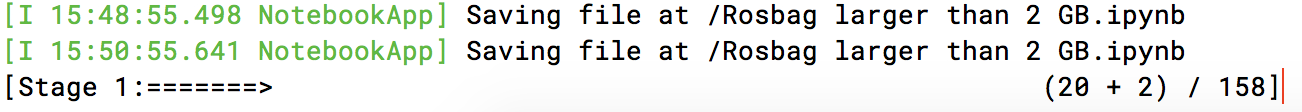

# Have Fun!